In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import clip
from data_utils import *
import json, faiss
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'IMG_WIDTH': 224,
    'IMG_HEIGHT': 224,
    'TEST_DATASET_DIR': 'data/val2014',
    'batch_size': 16,
    'epochs': 80,
    'n_neighbors': 5,
    'classifier': 'knn',
    'text_encoder_type': 'ft',
    'mode': "img2text",
    'metric': 'cosine',
    'voronoi_cells': 64,
    'lookup_cells': 8,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

In [3]:
# File containing images info (file_name)
with open(f"data/captions_val2014.json", 'r') as f:
    captions_val = json.load(f)

# Dataset for the retrieval
retrieval_dataset = CocoMetricDataset(
    root=config["TEST_DATASET_DIR"],
    captions_file=captions_val,
    transforms=CustomTransform(config, mode="clip"))

# total_length = len(retrieval_dataset)
# train_size = int(0.6 * total_length)  # e.g., 60% for training
# valid_size = int(0.2 * total_length)  # e.g., 20% for validation
# test_size = total_length - train_size - valid_size # remaining 20% for testing
# train_dataset, validation_dataset, test_dataset = random_split(retrieval_dataset, [train_size, valid_size, test_size])

dataloader = DataLoader(retrieval_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=coco_collator)
# dataloader_validation = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=coco_collator)
# dataloader_test = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=coco_collator)

Creating image-answer pairs...: 100%|██████████| 1000/1000 [00:01<00:00, 585.67it/s]


In [4]:
# Model Definition remains the same
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.model, _ = clip.load("RN50")
        
    def forward(self, image, captions):
        text_tokens = clip.tokenize(captions).to(image.device)
        return self.model.encode_image(image), self.model.encode_text(text_tokens)

model = Net()
model = model.to(config['device'])

In [5]:
def extract_features(loader, model, device, mode=None):
    model.eval()
    with torch.no_grad():
        db_features, query_features, labels = [], [], []
        for img, captions, label in tqdm(loader, total=len(loader), desc='Extracting features'):
            img_f, text_f = model(img.to(device), captions)
            if mode == "img2text":
                db_features.append(text_f.cpu().numpy())
                query_features.append(img_f.cpu().numpy())
            else:
                db_features.append(img_f.cpu().numpy())
                query_features.append(text_f.cpu().numpy())

            labels.append(label)
        return np.concatenate(db_features).astype('float32'), np.concatenate(query_features).astype('float32'), np.concatenate(labels)

# k-NN Classifier for Image Retrieval
class ImageRetrievalSystem:
    def __init__(self, model, database_loader, config):
        self.model = model
        self.database_loader = database_loader
        self.device = config['device']
        self.mode = config['mode']

        self.dim = 1024
        self.classifier_type = config['classifier']
        self.n_neighbors = config['n_neighbors']

        if self.classifier_type == 'knn':
            self.classifier = NearestNeighbors(n_neighbors=config['n_neighbors'], metric=config['metric'])
        else:
            self.classifier = faiss.IndexIVFFlat(faiss.IndexFlatL2(self.dim), self.dim, config['voronoi_cells'])
            self.classifier.nprobe = config['lookup_cells']

    def fit_and_retrieve(self):

        db_features, query_features, labels = extract_features(self.database_loader, self.model, self.device, mode=self.mode)
        
        if self.classifier_type == 'knn':
            self.classifier.fit(db_features)
            _, predictions = self.classifier.kneighbors(query_features, return_distance=True)
        else:
            self.classifier.train(db_features)
            self.classifier.add(db_features)
            _, predictions = self.classifier.search(query_features, self.n_neighbors)

        return predictions, labels   

In [6]:
def evaluate(predictions, labels):

    # Prec@1
    prec_at_1 = np.mean([1 if predictions[i, 0] == labels[i] else 0 for i in range(predictions.shape[0])])

    # Prec@5
    prec_at_5 = np.mean([np.any([1 if predictions[i, j] == labels[i] else 0 for j in range(config['n_neighbors'])]) for i in range(predictions.shape[0])])

    # Initialize list to store average precision for each query
    average_precisions = []

    # Compute binary relevance arrays and calculate average precision for each query
    for i in range(predictions.shape[0]):
        # Convert true label into binary format for each prediction
        binary_relevance = np.array([1 if label == labels[i] else 0 for label in predictions[i]])
        
        # Ensure there is at least one positive class to avoid division by zero in AP score calculation
        if np.sum(binary_relevance) > 0:
            # Compute the average precision for the current query
            ap_score = average_precision_score(binary_relevance, np.ones_like(binary_relevance))
            average_precisions.append(ap_score)

    # Compute mean Average Precision (mAP) by averaging all the AP scores
    mean_ap = np.mean(average_precisions)

    return prec_at_1, prec_at_5, mean_ap

In [7]:
pipeline = ImageRetrievalSystem(model, dataloader, config)
predictions_idx, labels = pipeline.fit_and_retrieve()

predictions = labels[predictions_idx]

prec_at_1, prec_at_5, mean_ap = evaluate(predictions, labels)

print(f'Precision at 1: {prec_at_1:.4f}')
print(f'Precision at 5: {prec_at_5:.4f}')
print(f'Mean Average Precision: {mean_ap:.4f}')

Extracting features: 100%|██████████| 63/63 [05:00<00:00,  4.77s/it]


Precision at 1: 0.5360
Precision at 5: 0.8270
Mean Average Precision: 0.2029


In [62]:
n = 2
retrieval_vis_data = [retrieval_dataset[x] for x in np.unique(predictions_idx[:n].flatten())]
gt_vis_data = [retrieval_dataset[x] for x in range(n)]

retrieved_embeddings = []
for img, text, _ in retrieval_vis_data:
    with torch.no_grad():
        img_f, text_f = model(img.unsqueeze(0).to(config['device']), [text])
    if config['mode'] == "img2text":
        retrieved_embeddings.append(text_f.cpu().numpy())
    else:
        retrieved_embeddings.append(img_f.cpu().numpy())

gt_embeddings, query_embeddings = [], []
for img, text, _ in gt_vis_data:
    with torch.no_grad():
        img_f, text_f = model(img.unsqueeze(0).to(config['device']), [text])
    if config['mode'] == "img2text":
        gt_embeddings.append(text_f.cpu().numpy())
        query_embeddings.append(img_f.cpu().numpy())
    else:
        gt_embeddings.append(img_f.cpu().numpy())
        query_embeddings.append(text_f.cpu().numpy())

retrieved_embeddings = np.concatenate(retrieved_embeddings).astype('float32')
query_embeddings = np.concatenate(query_embeddings).astype('float32')
gt_embeddings = np.concatenate(gt_embeddings).astype('float32')

In [59]:
# Function to denormalize image
def denormalize(normalized_img):
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
    denormalized_img = normalized_img * std[:, None, None] + mean[:, None, None]
    return denormalized_img

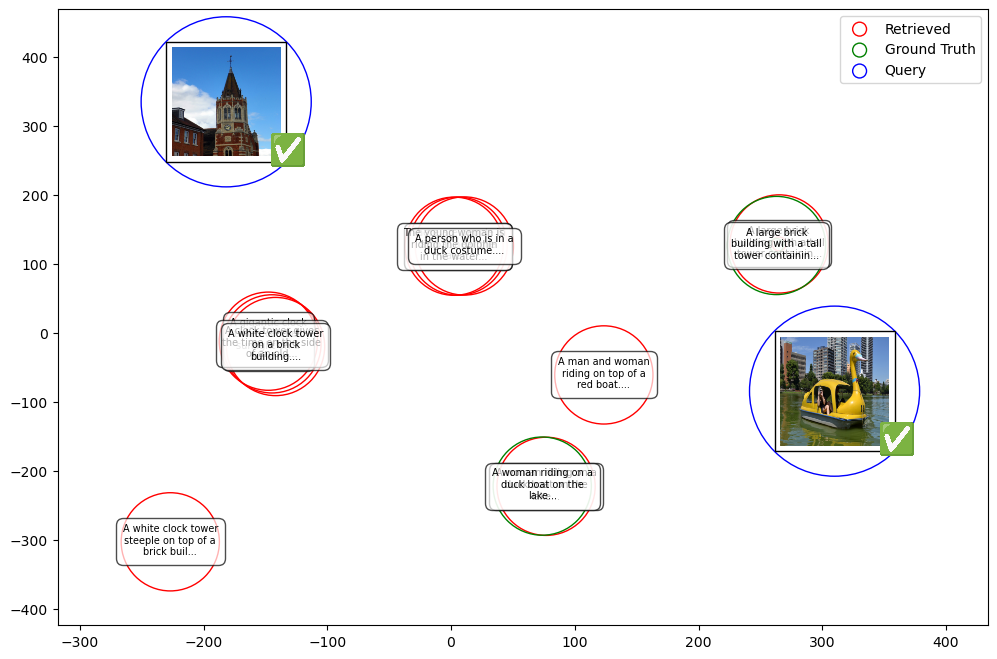

In [137]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import textwrap
from sklearn.manifold import TSNE
import matplotlib.lines as mlines
from imojify import imojify

textlength = 50

# Combine both sets of embeddings for UMAP
combined_embeddings = np.vstack([query_embeddings, retrieved_embeddings, gt_embeddings]).reshape(-1, pipeline.dim)

# Perform t-SNE on the combined embeddings
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=0.001, metric=config['metric'], random_state=123).fit_transform(combined_embeddings)

# Split the transformed embeddings back into queries and images
queries_2d, retrieved_2d, gt_2d = X_embedded[:len(query_embeddings)], X_embedded[len(query_embeddings):len(query_embeddings)+len(retrieved_embeddings)], X_embedded[len(query_embeddings)+len(retrieved_embeddings):]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot retrieved
for i, (x, y) in enumerate(retrieved_2d):
    if config['mode'] == "img2text": # retrieve text
        text = textwrap.fill(retrieval_vis_data[i][1][:textlength]+'...', width=20)
        text_box = TextArea(text, textprops=dict(color='black', size=7, ha='center', va='bottom'))
        ab = AnnotationBbox(text_box, (x, y), frameon=True, bboxprops=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.7))
        ax.add_artist(ab)
    else:
        img = denormalize(retrieval_vis_data[i][0]).permute(1, 2, 0)
        imgbox = OffsetImage(img, zoom=0.35)
        ab = AnnotationBbox(imgbox, (x, y), frameon=True)
        ax.add_artist(ab)
    # plot a red circle around the retrieved with legend
    if i == 0:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors='red', label='Retrieved')
    ax.scatter(x, y, s=5000, facecolors='none', edgecolors='red')

# Plot gt
for i, (x, y) in enumerate(gt_2d):
    if config['mode'] == "img2text": # retrieve text
        text = textwrap.fill(gt_vis_data[i][1][:textlength]+'...', width=20)
        text_box = TextArea(text, textprops=dict(color='black', size=7, ha='center', va='bottom'))
        ab = AnnotationBbox(text_box, (x, y), frameon=True, bboxprops=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.7))
        ax.add_artist(ab)
    else:
        img = denormalize(gt_vis_data[i][0]).permute(1, 2, 0)
        ax.add_artist(AnnotationBbox(OffsetImage(img, zoom=0.35), (x, y), frameon=True))
    # plot a blue circle around the gt with legend
    if i == 0:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors='green', label='Ground Truth')
    ax.scatter(x, y, s=5000, facecolors='none', edgecolors='green')

# PLot query
for i, (x, y) in enumerate(queries_2d):
    if config['mode'] == "img2text":
        img = denormalize(gt_vis_data[i][0]).permute(1, 2, 0)
        ax.add_artist(AnnotationBbox(OffsetImage(img, zoom=0.35), (x, y), frameon=True))
        if predictions[i][0] == labels[i]:
            #plot a green tick emoji in the right bottom corner
            img = plt.imread(imojify.get_img_path('✅'))
            ax.add_artist(AnnotationBbox(OffsetImage(img, zoom=0.05), (x+50, y-70), frameon=False))
    else:
        text = textwrap.fill(gt_vis_data[i][1][:textlength]+'...', width=20)
        text_box = TextArea(text, textprops=dict(color='black', size=7, ha='center', va='bottom'))
        ab = AnnotationBbox(text_box, (x, y), frameon=True, bboxprops=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.7))
        ax.add_artist(ab)
    
    # plot a blue circle around the query with legend
    if i == 0:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors='blue', label='Query')
    ax.scatter(x, y, s=15000, facecolors='none', edgecolors='blue')

xmin = X_embedded[:, 0].min()
xmax = X_embedded[:, 0].max()
ymin = X_embedded[:, 1].min()
ymax = X_embedded[:, 1].max()
ax.set_xlim(xmin - abs(0.4 * xmin), xmax + abs(0.4 * xmax))
ax.set_ylim(ymin - abs(0.4 * ymin), ymax + abs(0.4 * ymax))
plt.legend()
plt.show()